In [1]:
# Colab install cell — run once at top
# Ultralytics provides SAM2; Hugging Face transformers gives GroundingDINO pipeline.
# Install core libs
!pip install -q ultralytics transformers accelerate safetensors ftfy timm --upgrade

# Optional: image display helpers
!pip install -q matplotlib pillow opencv-python-headless

# NOTE: installing extra / alternative GroundingDINO repos is possible,
# but HF 'zero-shot-object-detection' pipeline with GroundingDINO models is easiest.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 151.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00


In [2]:
# Colab Python cell
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
import torch

# device: for HuggingFace pipeline, device index (0 for GPU), -1 for CPU.
device_for_hf = 0 if torch.cuda.is_available() else -1
print("HF pipeline device:", device_for_hf, " torch.cuda:", torch.cuda.is_available())


HF pipeline device: 0  torch.cuda: True


In [3]:
# Load an image by URL or upload (simple helper)
from urllib.request import urlopen
from io import BytesIO

def load_image_from_url(url, resize_to=None):
    resp = urlopen(url)
    img = Image.open(BytesIO(resp.read())).convert("RGB")
    if resize_to is not None:
        img = img.resize(resize_to, Image.BICUBIC)
    return img

def show_image(img, figsize=(8,8), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(np.asarray(img))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Example quick test:
# img = load_image_from_url("https://raw.githubusercontent.com/roboflow-ai/notebooks/main/notebooks/images/bus.jpg")
# show_image(img, title="Example image")


In [4]:
# Hugging Face pipeline for GroundingDINO (zero-shot object detection)
from transformers import pipeline

# Choose a checkpoint: e.g., "IDEA-Research/grounding-dino-base" or tiny for speed.
detector_id = "IDEA-Research/grounding-dino-tiny"  # smaller & faster; try base for better quality
print("Loading GroundingDINO pipeline (this may download weights)...")
gd_pipeline = pipeline(task="zero-shot-object-detection", model=detector_id, device=device_for_hf)
print("GroundingDINO pipeline loaded.")


Loading GroundingDINO pipeline (this may download weights)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


GroundingDINO pipeline loaded.


In [5]:
# Ultralytics provides a convenient SAM 2 wrapper
from ultralytics import SAM

# Use small / base model. On first run it will download the model weights automatically.
# Options: "sam2_t.pt" (tiny), "sam2_s.pt", "sam2_b.pt", "sam2_l.pt", or "sam2.1_b.pt" etc.
sam_model_id = "sam2_b.pt"  # tune: tiny->fast / b or l for quality
print("Loading SAM 2 model (weights will download automatically if needed)...")
sam_model = SAM(sam_model_id)
print("SAM 2 ready.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading SAM 2 model (weights will download automatically if needed)...
SAM 2 ready.


In [13]:
# Full pipeline: run detector on the image with a text prompt,
# extract boxes above thresholds, call SAM with boxes as prompts, show overlays.

def grounding_to_boxes_and_phrases(image_pil, text_prompt, box_threshold=0.35, text_threshold=0.25, top_k=5):
    """
    Returns a list of boxes (x0,y0,x1,y1), their scores and phrases according to GroundingDINO pipeline.
    box_threshold: objectness threshold
    text_threshold: phrase matching threshold
    top_k: pick top-k boxes by score
    """
    # GroundingDINO HF pipeline expects PIL image
    outputs = gd_pipeline(image_pil, candidate_labels=[text_prompt])
    # outputs is a list (batch) — take first
    out = outputs[0]
    boxes = out.get("boxes", [])  # each box: [x0,y0,x1,y1]
    scores = out.get("scores", [])
    phrases = out.get("labels", [])  # predicted phrase/label text
    # Filter by box_threshold
    filtered = []
    for b, s, p in zip(boxes, scores, phrases):
        if s >= box_threshold:
            filtered.append((b, float(s), p))
    # sort by score desc
    filtered = sorted(filtered, key=lambda x: x[1], reverse=True)[:top_k]
    return filtered

def run_text_to_mask(image_pil, text_prompt, box_threshold=0.35, top_k=5, visualize=True):
    """
    Robust text->mask pipeline: GroundingDINO → SAM2
    If no boxes are detected, automatically lowers threshold and tries simplified prompt.
    """
    # 1) First attempt
    preds = grounding_to_boxes_and_phrases(image_pil, text_prompt, box_threshold=box_threshold, top_k=top_k)

    # 2) Fallback: lower threshold
    if len(preds) == 0 and box_threshold > 0.2:
        print(f"No boxes detected at threshold={box_threshold}. Lowering threshold to 0.2 and retrying...")
        preds = grounding_to_boxes_and_phrases(image_pil, text_prompt, box_threshold=0.2, top_k=top_k)

    # 3) Fallback: simplify prompt (remove adjectives)
    if len(preds) == 0:
        simple_prompt = text_prompt.split()[-1]  # take last word as noun (simple heuristic)
        print(f"No boxes detected with fallback threshold. Trying simplified prompt: '{simple_prompt}'")
        preds = grounding_to_boxes_and_phrases(image_pil, simple_prompt, box_threshold=0.2, top_k=top_k)

    if len(preds) == 0:
        print("Still no boxes detected. Try a different prompt or image.")
        return None

    boxes = [p[0] for p in preds]  # list of [x0,y0,x1,y1]
    phrases = [p[2] for p in preds]
    scores = [p[1] for p in preds]

    print(f"Found {len(boxes)} boxes. Passing to SAM...")

    # Convert PIL->numpy
    img_arr = np.asarray(image_pil)

    # SAM: feed boxes
    sam_results = sam_model(img_arr, bboxes=boxes)

    # Parse SAM masks
    final_masks = []
    try:
        r = sam_results[0]
        masks = r.masks.data  # shape (N, H, W)
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()
        for i, m in enumerate(masks):
            final_masks.append({
                "mask": m,
                "phrase": phrases[i] if i < len(phrases) else f"obj_{i}",
                "score": scores[i] if i < len(scores) else None
            })
    except Exception as e:
        print("Warning parsing SAM results:", e)
        return sam_results

    # Visualize
    if visualize:
        overlay_masks_on_image(img_arr, final_masks)

    return final_masks



# def run_text_to_mask(image_pil, text_prompt, box_threshold=0.35, top_k=5, visualize=True):
#     # 1) get boxes from GroundingDINO
#     preds = grounding_to_boxes_and_phrases(image_pil, text_prompt, box_threshold=box_threshold, top_k=top_k)
#     if len(preds) == 0:
#         print("No boxes detected above threshold. Try lowering box_threshold or changing prompt.")
#         return None

#     boxes = [p[0] for p in preds]  # list of [x0,y0,x1,y1]
#     phrases = [p[2] for p in preds]
#     scores = [p[1] for p in preds]

#     print(f"Found {len(boxes)} boxes. Passing to SAM...")

#     # Convert PIL->numpy (H,W,3)
#     img_arr = np.asarray(image_pil)

#     # SAM expects (image, bboxes=[])
#     # Ultralytics SAM uses bboxes as [x0, y0, x1, y1] in pixels
#     sam_results = sam_model(img_arr, bboxes=boxes)

#     # 'sam_results' is an Ultralytics Results object; access masks
#     # The structure can vary, but typically sam_results[0].masks.data or .masks.x
#     # Convert to boolean masks for overlay
#     final_masks = []
#     # ultralytics returns a list of Results, each with .masks (masks.data -> NxHxW boolean)
#     try:
#         # If single image
#         r = sam_results[0]
#         masks = r.masks.data  # shape (N, H, W) or a list
#         # If masks is torch.Tensor convert to numpy
#         if isinstance(masks, torch.Tensor):
#             masks = masks.cpu().numpy()
#         # pair masks with phrases
#         for i, m in enumerate(masks):
#             final_masks.append({"mask": m, "phrase": phrases[i] if i < len(phrases) else f"obj_{i}", "score": scores[i] if i < len(scores) else None})
#     except Exception as e:
#         # fallback: try results.masks.xy or .masks.x or result.masks[0]
#         print("Warning parsing SAM results:", e)
#         # print(sam_results)
#         return sam_results

#     # visualize overlay
#     if visualize:
#         overlay_masks_on_image(img_arr, final_masks)

#     return final_masks

def overlay_masks_on_image(image_np, masks_info, alpha=0.5, figsize=(10,10)):
    """
    image_np: HxWx3 uint8
    masks_info: list of dicts {"mask":HxW bool or 0/1, "phrase":str}
    """
    import random
    H, W, _ = image_np.shape
    plt.figure(figsize=figsize)
    plt.imshow(image_np)
    for info in masks_info:
        m = info["mask"]
        if m.dtype != np.bool_:
            m = m.astype(bool)
        color = np.array([random.random(), random.random(), random.random()])
        colored = np.zeros_like(image_np, dtype=float)
        for c in range(3):
            colored[..., c] = color[c]
        # overlay only where mask True
        plt.imshow(np.dstack((colored * m[...,None])) , alpha=alpha)
        # compute centroid for annotation
        ys, xs = np.where(m)
        if len(xs)>0:
            cx, cy = int(xs.mean()), int(ys.mean())
            plt.text(cx, cy, info.get("phrase", ""), color="white", fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    plt.axis('off')
    plt.show()

# Example usage prompt (run after you load an image):
# masks = run_text_to_mask(img, "a red bus", box_threshold=0.3, top_k=3)


Options:
1) Provide image URL
2) Upload file from local
Choose 1 or 2: 1
Paste image URL: 

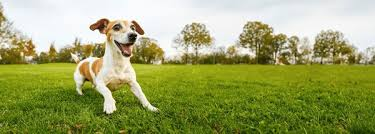

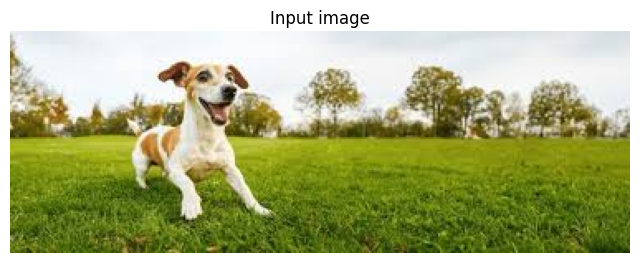

KeyboardInterrupt: Interrupted by user

In [20]:
# Simple interactive cell: either provide URL or use file upload
from google.colab import files

def interactive_test():
    print("Options:\n1) Provide image URL\n2) Upload file from local")
    choice = input("Choose 1 or 2: ").strip()
    if choice == "1":
        url = input("Paste image URL: ").strip()
        img = load_image_from_url(url)
    else:
        uploaded = files.upload()
        if len(uploaded)==0:
            raise SystemExit("No file uploaded.")
        # pick first file
        fname = list(uploaded.keys())[0]
        img = Image.open(fname).convert("RGB")
    show_image(img, title="Input image")
    prompt = input("Enter text prompt to segment (e.g., 'red bicycle', 'man with hat', 'white dog'): ").strip()
    masks = run_text_to_mask(img, prompt, box_threshold=0.35, top_k=5)
    print("Done. returned masks:", None if masks is None else len(masks))

interactive_test()


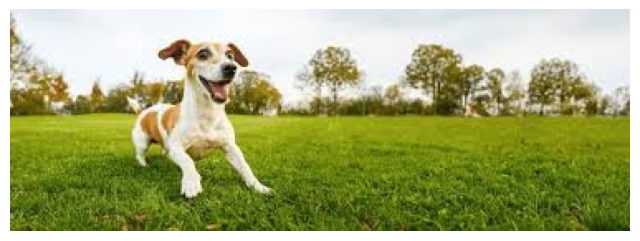

No boxes detected at threshold=0.35. Lowering threshold to 0.2 and retrying...
No boxes detected with fallback threshold. Trying simplified prompt: 'dog'
Still no boxes detected. Try a different prompt or image.


In [21]:
img = load_image_from_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFhUXGBcZGBYWGBUZHRgdFhoXGhcZGBoaHyggGh0lHhUYITEiJikrLi4uGB8zODMsNygtLi0BCgoKDg0OGxAQGy0lHyUtLS0tLS0tLS0tLy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAIYBdwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAADAAECBAUGBwj/xAA/EAABAgQEBAQEBgADBwUAAAABAhEAAyExBBJBUQUiYXEGE4GRMqGx8BRCUsHR4SOS8QcVFjNDU2IkcoKisv/EABoBAAMBAQEBAAAAAAAAAAAAAAABAgMEBQb/xAArEQACAgEEAgECBgMBAAAAAAAAAQIRAxIhMUETUQQiYTJCcYGRsQUUwSP/2gAMAwEAAhEDEQA/APWOGzxMQ7uRQ6Vg6kxi+CuIJmyAsUq2XZvr3jossEJaopoUlToq5YYCLeWI5YskAIKkw5TDhMIY4XEwYgExIQAPDNEwIdoABtChyITQANDiHaHAgAaHEO0KAKHhQoUIY0JoeFABFoYxKE8AA1CBqEHiBgsCqoRDLFsiIkQ7FRWyQxEWCmG8qCwoqkwhFnyYbyYLFQECHeC+VC8qAdACYYAxYEqJBMAqK/lmF5UWDEYABCVD+VE3h3gGD8uH8uCCJgQrCgHlw+SDERApgGQIgaoIRECiGhAjDNBvLheXAIFlhosBEKCx0cN4fwk6WpE1LJQpDlJJq35m/iO6wuPStgC5Idth1jkMPxBGRMuUqgQHUSCpKQKhhG7w2ekArBBe51J2PaOfAlGNIue7s3YUBkYlKrGv0iwI6CCLQ7Q7QmgAQEPDQ8AEoURh4QxQOdOSgFSlBKRcqIAHqYnHmPjngWOn4ogIVNlKIEoBTISGD5qskvmcm70e0Rkm4rZWXjipOm6CeKP9p/lqKMKlJYkGYtyC2wBHzi34Q8czZsxUnFIS4SFZ5YLVs4jyzxL4ZxcmemRNSkZgCjISpLEtelXEdpwZCkEyU5lrpnUWBASAAknWr1jhy5Zw3vc7Y4sclSW3s9I/4gl1IByi6lUHaDq4skEApPNUGjR4dxnB4yZiSFylrHwpyqXlQNMiRRg7kmp1j03w+FCSiVOUFLSeU6to+9DGnknS+rcw0RvjY1uP+K5WEKPMRMKVlitKXCe5/aNnC4lExCVoUFJUHChYiPOfGfCcQqcD/iTMOtJSyVMEKSl0hSPzuX6h6VEYf+zfxZ+GX5E1R8lZDE/9NVraA2O1940WVqX1cC8SlG48o9meGeI5oWaOo5iUKIPDvCGShmivjsamUgrWQAN9ekcoueuYqarOopUkEZFCtiQlT8qQ/wBYiUqGlZ1EniMlT5ZqC1+YUi0CDqI8wwSHyyphKV5qFLOQay8xsR/UdDwXG5ZqUrW6ggmYqrF7ObEiMcebVyXKNHXw0QQsEAguDYxJ46CB4aE8NABCasJBUbAOfSMpXiTDsTmVQO2Uu28UPGBzkSitKRkUQk5xmLG5ToALdY4peJSomZ5jpHKQkEZEmjJ/VbXeObLmlB0i4xTPReGeIcPPOWWtzcgghu7xpZo8gRMmzlKmSfLSwLcwSpTDYXMbfh7iU2QSCUkLCQCtZAQWJYjen0iMfy5XU1+45Y10z0IwgIhgJ3mS0rZnDttFkJjtsxogERIIiYEPCsdEQmHaJNCaAZFoWWBjFI5uYct/vWIycYhVjo9aONxCtAFKIbJDy5qVVSQe0ShgQywssSJhngAi0KHJhQCOHkYApSqV5WZX5piWdQNw9PWBoVNlpXLQgoQkiqyWKXqBl+sb8rComOgqWMrkqzAJUrVwNIx/EODmTmQlY5SQxJDkbfKOKdxjcTZU3uaX49CCgpZ1fUNTeNfD8QDEqpci8edYnGTUTES1qRLSn4VoLkEUcqN632huL45RKECZMzgpKkLDZiHUV5tQdBEL5tXtwV4NTPVkmkO8ZPhzjCcTKC0UahHUAPGrHoRkpK0c8k06Y7w8Y03iqfxIw71ABP8AB+Uai5oF4aknwJpoLAJuLSlYQTUgkdheKi+MSwWJpv8A1eOQ8Q8aVLnLW6VEywmWU1Z1HM9XtGeTLGCtlRg2egIUCHFok0cojxhJTLBZRAGzFx0JgEvxsgpUoAhksAqrq0tqf3iH8rEnWorxTq6Ol4lwmTPbzUBWX4SXBDs7EVFo4PjuBTh8WJcpZSJhzqJJLBKapcmo5C3eNE+OJmZSPKQ6Qkq5jQq0YtUas8D4ngzPlyp6qryu/cm3yjm+RKOTaK3W5tibhzwaODKvhcEU0D1H9wXFlMtC1BIC2IBAqLs5jgfFSMRIWMdhVEFkpnS/yqyhkqI2IYPoQNHjN4l42xRR/wApC3DhQzAHuk2I2fSNouKSZGmUuDnsd4zxqcRSfl5gAOYsXHMpg99n1Z49Q4p4fwi0yp+KEz8QUSzO8gZQtRAcqSQWPZi0cL4Y8NzJk1GLxEuWmW5UEAqzLVcC9BS8d7xjjCJkvOkEVIJ+F3AAA/UxhSnFp2OpRZ1OB45IWQhJUlhQKSoUGjnaNKWsKDpII6R5rgMZ5aETCXDkkOCXqzp2amm8b3hzxAFq/wARASoD4hQV0O0LH8uOpQlyS8Tq0deERGcsJDmDiKHFZaFDKssGvHXZlRn4qdLmBWY5gnmSxsQ9A17R5zI4ulNZY/xEqI8oJKkqC3qsOz6NHfTeHvUAzBRrByaOSLgCMLBeGwZ0zKEkgrVmCTdQICQ1lBi77xy5oyk1RpFpHOTsYonMJeVKQzADIFVBVepcUMPwfGlgFKlpSnmAKM2cpeg611jSxvBFpKWKlhCSpKSUAhlACURb8zktFmd4SLZidqA/DmDt1SCb3jjeLLdo11Ro6jwzxxE2Sh/iqDsK0jeeOX8P4LykhLMzOCcx9+u0dCvEoTQqD7R6WFy0LVyYTq9gzwLFzsqFKAcgEgCFNxCEpCioAG3WOf4lxHzAFSnIdnqK1FNjFOcVt2JJnJ4zis2ZKJXMAdX/ADX2f8nxIpT1jFwUxBUpkqKACZoGYprWWWudaWizO8PPiss1WRyGWokZiWdhlHN0tFabhsk2cgKmzkpQUBri7Ags7R58tV2zbYng8ShErNLZVk5CwqTm5gN9n0ing+KETfOWEKIJ5FAZdQXT6mK/4aWlI5wAmXKmEgl1GYCCkdQUkxTGAWtJUlSTqa1amnrGGSLtJFJnoMzx8oAS5KQxAZQSaMBmCUm4EX/DviqatYSohaKqJuQnqRYjaPNeEY1QmyipKVuSkBRIYk6aD+I7rw7g0oInYicEAKKZaPhTdVDSoJG8dMPI2nqIbXo63HeJ0pGaWgzEgAlTsK2YGpjQ4bxZE6X5gcaEG4I0jy7F8RSnECZJJ+PnQVUYVcOPhJjtcFklSgskAzObKHck3PzjeGVuTJcdjo8JjkzHy6Rnce4r5RCQW1UpwGTUExX4VPSFMCSdepP9RyHjbi74pmYSxluCSSxBKdQNorJl0xsSjbDYjiLKWTNzKCqeW5YKYOpO9SYhi8QiUoNMmKK1BISNAaH4qA1B9Y46ZxYApSVAkkrdIKFOo1B7aRcnTcq2zlSkALSlgWzKBcr1uPsRyPLtwaJHf8DKwmnLlmkAA0Ol9u+0dbLmg2LtePJp3F5rMnMkzBRSlMlkjmCXo/W8dVwHjyEpSFnmAyllZnbWOjF8iD2IlBnYvDPFTA45M1IKSH2iwY60ZEiqFADiEfqBfYwoewHi8rHTCtac5zVdKnZSnZlOYAviyyoGbXKMrF2F2s1oysbxUzVrnMlAUpyE2c/R7xXRicwd6WjwZqXfB1qSO04Jhk4nOAUpMtBU5D5jU1reK/EZyp4QFpBUNQ7kXGbSl/WMbhWITLUog0IIauojueG+LAmWMiAtSU5fyuGYJ6wseJS2ujRZHHo2/BXFsqRIWQC3KMuUZUipJ1OsTR47QZhQZRAflU7gjctZ/wB4804tPxAX5iywzVYZTVyxo1jGZLxK2oCam2Y0PaOrzTxQUb4MHpcrOpx+LUvHKnCYEqzguC45WA70FY1fEHi4LKAygw5gDcilCDaOQneazIlKqASSk3GgpFPEysSv/oqG7IYe0c2PK439S3Kk06NrCcUWuYJaZpSla2c2BUQ2ZuoDxq43w3NQha5oEpWcMVKSEEGjhQ+6xx2DwUxK0mZKm5QXYJNG1+Uei8P8S/icOZK5ajNKgAkpOr5VAK9j+zxrDxveTsE29kcrjJilIYKDm6WIIajnSBzMEtGHRMe6lUc1IHKetQY7QeHZKJ/nYuaHamHlfAkEMcxZy/pHRY78IJKFqlIUgBpYKQT0Z6iK/wBeOpybW29D1SpKuTxPEYgjNMJJmFQu9QXBI1ew9eke18PwhRhZUtQqmUgEdQBm+bxz+B4dh1z0zkYdCFFQNHL1BBZRIHoBHXYi57Rv8apW/wBiMsHCkzk8ZOKUlkhaXyqSdU1BAjhsWqThJsyTOSsSip5KgSSEqDuaVqW9DrHouIwwJIdnJ6dY0JHCpU2WETZaJgBpmDwld0y4ycd0ef4XiSjhpUxHPJRNUMwJD8qbPoz+8c9isYUoWmrlRLl6A1AAanfWNPx35svFrlBBEpIHloSDlCSkPlADAk5vV457BY8BC5UyWSF/mLuGqGeOWT+phOVuy5JxbAkmujNGzgsQtSFGqEhidlPZwN4wsShE6ZJlpISCEeYogJCSARppQF+sdpwDgCigIBBQohQUS9CkNpQCMv8AW1cDU6Or8C8QmLl5FAZR8J17fe8dUtQapEeW4Di/4WfOlqmhgUpSW1bmN6AsIliPHqMqkFKmoxNzu+1dY9DDmjDGot7oynG5WegTJ6UpIcZUi1qdC9IwOF+IsOlU0pejApaoZzWvW/aOQ4t4qlz5SkAhJSQxdw24a46RzvD5iipSnWHJqA4bKKNreFLO9X0goqj0j/eEk4mVOCXC0LdT1ATl5WBjcVxmQlNSECnLR3PaPFJOJUCFuogO1a0bawivjvEM02PxO4v93iV8iXSBxXZ7DxPxDJSWBSuoewvY9hGHP8US15VgAHmZ9b0PQ/tHlkrFkhRJLhKniaEq2IBDuQYH8idCSTPU+LcUM0IWhOaWAAwNSW22f1pFnw9jjKaXMWE5udjVgqwra8eYJ49OShKM9EkEBh6QHE8RV8RzZiA1y4J0iPJctVbl8Kj3mZxrDIQCtYvqHr03jPxvDUTCZ6JmYFK6IIBO1rtWPEsfipii58zlFMwOlI1pfimciUJQVl5CDuQbdmjR/I6aJUSpj56VL5lKTlloGUh8xSCw6X+cAkSzmCpSSSQAUg6nf10jH4hOWVKcnS+tBFvgctZUFCZkKQTUULadaRnGHYWdxwjgKqTVTFZfw6pgSkVC5hUhgDT8tYn/AMRYWWUykYXzFBIcqBIJ3bUV2i1w2YteHmgghUtKES1pLBbZ1lLMH+Oojm5mImyMQFzs2Zg/5cySxbtTTaKeTTSSK0WrNTjvEBOlCdLRkZCjMAysGLDL3em0bOD8SyPw0uXlK50tIAo7jckWZ69onIloMhZQuWtC0TSwSMoBFBv0YxzuH4qg4nMhMuSaCvwuAxLDSnzhttb+xHTcIOIJICSQSmpJTR6qSTHO+IJWXFzVjKopdXOrmW4q1CNGAjbk+JMuZUyqUoKeWzmpL/d4Dg8RggpigKdgCoGzOSR+WsCcWqv+QdnJ8KmhCyGSCqvmK58ia8mWgU5asavFlKl4WSAEKQuYHIBSt3JLsHbtoI0sIrBTHm+UVKVMmBOUM2UsA21Ir8V4mnInlmBKSKKSWoFPle2sQ04pjRmYrhk/yjOJCwhfloCXq9SQNGp1iOAwOJlqClpCBS+xLc2z9Yt8N8QzlZkywyUZVMwrVtrxHxnjlzEo+HMPjZKgXVUJL/EBvGNRa+5XB3HBuIS5aDNWXykudqUT6Rrf70E+WWo49C5pHjvD+IrGHVKUACuZ8an6D/LHaoxMuShKUzQsApSMpFCakjUjvHdhyuq6MpRR0+LmpkMwTlS9TT4tAbQo4TxFx0YopkyyVZL5jlchwSQO8KKllp7CUS2nhsr/ALaf8oiYwCBZCf8AKIrzFzLmkOicf1iPk3q7Y7LiMIgVyj/LBU4dAsG35WiijFqb4q9NYkMWp3zfOBWFl9QBoQ/cRJCU/bRnfjl0qG3aHOO3Jd7QO/1CzUCUfbRIS09flGYjFilX9Yn+JF/5MTa9Ds0AhPX5Rp8JlBKZk5AdSEnL3jmjPToo9mMdpwCck4ZPq/WpvHof47EsmX9FYaqODlY0zFrUsubkn0jX49MUqVhT+QpZ+r/18owPF02ThZ7heVKhlY9bVjW8M45M6RMwyiCQCUG7ZrEdifnHXHFJNwl3/Z3yyxaU10bnBcLmmEg0QQPVqRvTgHvAMLL8uWE6gOe+sBVPALKBL2bXoI9HFFYoU+TiyS8k76AYjDpzlNczOG/aLmAV5SOYuTQP9YqTsbKuvlKdXFovnGSVBNUqOljSJTV3Y6YDj+CC5fnCpSKtqP6/mOZOU/lf0juMMpK0kCxBFt3BEecHFLFAB8o8n/I41GamuyC8ZMu/lj2ETStItTShPtGYcQvb5wkzCXNQ24jzvJJcBZYmplkuUpJ1MCXLlF/8NJ7wFcxnesBOLHWJuTCwhw0n/tp9oLLZIYBhsIpebpvtSCIVo1YdyXYrDDAoFkpDjQbwE4WX+hPsIIZpNzfeBTVs7V7Qk5ewsQwaBXIn2EPMlAgAgEbHSAoxBPT1EEzDQw7kuwsGcEg/kT7CH/Cp/QB6Q57xIV1pvD1S9hZBUofpHtERhpf6U+wgqlMHiCVQan7HYKZh5ZoUJPcCIpw8oWQn0EGUl+8MAbWhqT9hZFKE2AYO7VvvB8XMMwZVnOBoqre8DEvqIgoM0PXL2FkEywBlCQBsKCGGHR+hPsIlmheZsG3h6pewsipLJKW5TppEMgtTtCmTRr0HrEgjoYdutwslKlhNgx6QVZKr17l4glJGsOVjq9bQtUvYDoJDtTfrEZoz3DtZ4ZYL3iJWHYwKUvYWTDgMwbakRmqdnSC1RSE43pCJHrFLJP2xDFNXZL9hChZhDQeSftgQTOZq06194KJjE2HzilLmF+YsQzgProekEkjM5FKFmNbbQ3AyTLIngk0f7pWDBaddeu8UklwWZ2Y/z3hTZFviJalb0cD6wtCHZdzigsT6b/xEkz3JJYlxX94oy56QMwSL6lyXFW2H9xUVi5bijlgRWlqn5N6GGsVi1GxLm1DlLUc19O0Fl4qW5cjMQ1D6N8owBihqEu3Wv21oDiMQfy5SLAgegaxoQYpYLYazphiQKH7943fDPFGExNGACgD1v20jzWfjF2JL0tvUHrpeNXwz4hEmaoTSMiwywRUCrH3MdPxMTx5VINdmlxebJxE9UybLBAGVKVMQf1Kb5Q/DfLkL82UEpSlISUA3zGmUbhrRzHidYGImFE0KkqIKSk25Q4p9+xinhsUEstKjQPfZ2jZxmsmtv9i/JTo+hpCwpIehIBIprHBeJ+LrkT/ICSNc635gdEaNuYfwd4yQspkzSErLBJNlPYdD/IjqfEvB04uQpCvjSCqWoXSoD5g2Ij0Mn/tj1Re5WOdM4SdxFag4y3Yu7esUpM1aRyLQ41Ys9gAHs8ZuDQhIOZalO5qWbQFh6XMX5eOllHw81Szhk2ZxchwRePHnkl+UuWbpHbeFOKkpc5szsvM5HoYpeKuFJkqExD+XMdtQlVyntqPXaKHh3iiUqCF0STRdDU6K6HeOwxmE8+SuSCAqipZO407Go9Y7XjXyPj/df2RJ3uefnFZQMwq9w/28OrEEA/b1HygGIUUkoUGKSQRZmofYiBJXSn5tbVNQNqACPG0Eaiecn9Qr29a3/wBIkpYTsYBPmLcCxAqCLBw/0iE7EM1R0e3UejfKKULFYZiSS1tQW9veGKy7AqpSrX6794pSMdoLnQk0fQ/esFOLod+1qRTg0Ky0iYSBv194JMLPRLl2b6xTMwPWh6tbeIT56EgKfXTT+Lj3idFsdhETBs25H32iCsUly6D3BHr9IHInIVUCop3eo+sHmJAd02tbr+9YuknuhElY9FE1f17vA14hAI5lAnQ9YgEh2CfQDtqIaavKHyjavpX5fKBRXQrDTVnRZAp/bxIzSbLF9tv9IH5r0Ia7E0bd4UsvYP1+emlIWkdhVzJg2V11HWJSsQtnKP5iMo6KVUgtQ6XiHmpAIUW7HQBq+v7wq+wyzKnpP5T3IhiuhI/aKM7EC2cktYDvUawRIIY5gQ7EjRrekHjDUFViGAD1arjWG8wAAqVU1Yf1AlFiQ7vUMXFtC0QmOkBRVlJBYp0AA136NDUUPUGmoBFa1fqOo6xGaFEMM3Sta9YD5x2cAXL/AGLiAnzFOMwse9NtwDFKDJ1F5EzQkvoIIJgfLWv5urWO0VZEtbMpSQdRdtoEMQsOCMygBRJa/wAqQtF8FKVFsrL771gSq6qDHp84nImkgzC35WHuFH0ga8TRgavp8/vrAouw1D5lFRszM3XeJJQLEkQMz1ZQSwOr/esTejs4NWGlT/rA0FhMo/UftoUBlzRqk1sRTU6Q0LSx2giAoODm6nfUWvQfIxMyUqYJUwajjKx96/1aKuEzm5JdwXKQBShSXq+g1YxUJW9RQXc6PQ0ra0b+NmdmjhlhFQo3cBxuG67/ACiK8SCW5XpvUinTW8ZuISoDOASwdTVH3eKyZilBwCCbBjWrEV2Or67iLWK9ybZrEKJJBqd6MToA+wPvekVvJLkKIINXHctcbA33eGThlLHxZSB8N6v0sa+4MC/DTKKzgtYB61YEi4Yn5xUY/cQdBYAAVYAjVnr8m9oEZaiwSkB7l9GIrTUNT97xxGdKFLJ7gA3FD8n9onhJvOlNqJPcnLlfQFlERVPkAZkLHoWYZiGJ1cahPpAZ2FUVVtobvUnX77xdGISrMWIIJDMWZLs/S/vDS5wqlQcXL6VYto20NSa6AoLSxBIq+rsRuPVvsRBUoaFk6l6OS7Wuxjel4QkklQFCTyhw6RZ+mkUsQGckMiuXU0zCg3J+phqYUUpcsGg0qllF3DM2t2HpH0DgFKCEZviypzd2D/OPAsJNIWhIeqwKAalL/faPfcFikrDoIUnMpLguHTQ/MGO74q5s0geXeP8ABDDYlOSqJozZAHKS7mjEEXIJrcaRgy8ahJXygEFykalqhx2sN47H/aNiJS1y1IWlU1CVS1pFSGYh9mKj7naOJlIlkBTkEi9AzP8AM1ckdI4csY6muvsOXJNWMRlV1YuH0NR309Y7PwH4kzKElSiSAGJZ6uQD2jkPweVQdy5DF63evv8A6NDqwhlzETZTZ0EFiQeYAFL7gg5Ttmgw5I45bMSdHdeP+HlP/qkpBQrLn/8AFQIGbsbd+8cVMnquEKBqRR+7jTt1Hp2Ph3xUlYXLxQTlV/h5SxADkKSdxauzRj8b4LhUHzcNPKakZCygASwIUKpBB1die5FZcMJXOP8AAPfgxZc9QIUokPf8zXd60p+8TxM8uylJIKXY039Rb1fWK86YEqrQAsxbra+pJG7GALUFF6O1X/Mw+E+3veObR2TZb85DGrH16ilNnhSsSBZjuQBRiH+t+sAnhLMoElqMHfKCaP6GBKypSC6mYMUkAgGtbe2/eBQTD7l6cS9Gdzd/VvlAgAKOEjuD9fWnSBykU+M9XDO5IBbSze/SC8rAEBeurjQndqg/dFprYCSQlwSDmYBJDVdg1NwYSCC5d9Xf0r7fOGnZQkJJbMOVi5SWYF9KNTpApsgrUJomAMTmAf3pup/fpCST5AuTAgALzkuPn+zN8ojNnS031H8U79e8Z/mkBYSUJLAnmABoxdj6PBUulTE/CE3sSKHLq0Px1yFlgkEhIdySxLi1W31OsVJC1lRckAg0sX0YWIcVrq0OlS8/wlQuG0dyCW+GtLawSRxGilFJ5SBVtX+YrFaWlsrEFViVnkU3wkGtFUav3tEfNyJzAOLsASa007igtC84KZwAQSKPX5MLFqw5nGgSpjqmj/8Ax0fcdonT1Q7GM5CwArMkvpQjT6iIYXEIPJ+Y1+jP1H7w09OdSTlymznZnd23H3qIJCWYqDWPR39KDTaKUVVCsvkuPiy6ODQP/QaKuIw/MCJpzOKKTTrlIP7RWlYvK4UijH4tgcv7isEKwpLJopwRlck6sBoctYFCUWDdkVTlJWoF6O1f26jSJYzMoZU50lqENrXW4akSMwksqpIvZVD11t7xZJSpNrZSFBy47D0tW+zQ+GnQIopUEak92+fRyKxZm4sK592zEClGFW7fKK03CcjzAzuxJDtbQuQ5B3iKZaggJNA1FUPWvq1DtDcYvcRdw8xD0WxLuD/XT6GGIKm1Crn9JYuR112jLGHZwQ5L8wOpqBF7IUuEnQM2lnc9Rfv0hPGlwxpliXKa66PSulGcHt84SkLyqqxNgKu5/p+0CE8JBzZcrNW7Va2v79oS52YfEXoXu9Nu8RpY7JCYczdKgt01PaFAZmIbmAdLbO5etPV/SFD0PpBaDYnEUCXcOTQ1JsCa7U6esDViEpDly2u9LNsxgknBISvKHWkc2fUkCiRS9+xbaM8YUr5SQlTsxqUl25Am+/3TXQrpsHZdlT84yhgFBtNQogD3t+8RlKyk5eZku2gLMe7sLmABDMgEEMdPiY3GoN21FfW0t6qQKqepIu/wkW0NQK9IGkuBAZaCRmSSAVAiulCX2vFmSh6lwMxUCWBeoAYaVIiExRCQwvmdNa0cd7n2EAmLdqZqkAKc7tq5LL/+sHIFpRQAEsGF2rmPNWttBE1AFRmA0p6Wt0o29YrcQCnURlCFEOQdakDZmSX94DOwxZBKnpVkrYEkNQtofVoFG+ytLL06QAsnMoAqIZjS9NWqX9YHJkpLK1VQUzAENrdiGLdXgk4rl85IUijsKjMAa9j87bQCQtK/+WpKR+kkuyqEPdwzNeFUhqDbpG0gscuZquGpUDaKONQVFSDQgpUGIqPzCnr8oqKnAA5VpJFHAa92Dvq0JeKFZgKllR/NpRjfQtaIUWnYpKuSurgyklLkzAo0YkAO7An00GnWLcjF4jDSlS5c+YJeaiEAuk5iouGKgCdelIniMQUtlsbqDsKOQRpf5ekQm4jzC4ZJSaNejuFG5SyjdrNG0cs1yF0QlywpRK3VmdyokO7XVW4JD9K9LS8NLI8sqJ2UAl+UUzVsW0pWM3iYCSA4CSASW/KXDZhWhAGu8EwyipDB1EDVTuLGut3iZcXYrJqnGrJUNHq1AW7WLDWHVN5iQaqUCxApuQN2PWwivLVMQAgoJTVx0cmlK3pBFKWnJyZpeYupzTuNCOb2EKhFqZNSVq1BIKXoerNvTs0UZ2FU5ewryqIJzAVLUuG62MJRJUxUSXdLOClixIILvan+kRxtFpCzlcE5ipi6hag5rv8AbRUFXAEpswrYJYlvzAgMoOG2NRc/QRTEsoUJi0kVsrmGhUxuQx1Easp2ysAx0sAdtgP2ipihzZCn8pIYg20a3Vnq8OM99IMJIWXLguAWZVGo7g9DrEZigEpBLZwaKYGjc1dHF+haKclas2YF+WoZqOU73paLc9GYubpbLU6AAd6l3htU9x3ew+C4i6wkhql731LdwPnB5E8BywUsA0GoZix9Cwo4HSM/8KpILVU3xXep+J7lmr/MOlCkqAPKXCgT+59PrCcIvgEwqZ81kqLtUuySwfre7xIEAMH6EJDt+Xs8VJ2JIWhK2S21AAS7jpUn0aDYXcVY3AJLMafuKw3HawUXyW0pQCCBlHKo0AJbfo+amjw+OxrLJSkEOPhq2UOK7HXvrA5GJ8whneoHb9+2/rDzUCimBvT0Aah9Yz/N9Qg54kkpIAyMfyVBfRxZ9m0gMnHyucFPMeVifSnVtesVZ/lliFZGymodjQAivbSJ4jAnIZhRmY8pAfoQT7FiN4pQgDYpmIonmJINwGGwzfKkETiVqSuWopSasU/CqoN9/wCdYfhWITKBKpaSXIcuWBA+la9W0iuAFqPOAOjsqte1oNrr12Ib8RNzFSWcnKQAGBAAJpQXHvFhOLDAEXUwpT01Z2MERk+DOwzOSA4DBqudgH7QyJaeYEOGooGoY0KbNe2op1gcovoaQczszEjOUl6jXamg6bvSKk/iPlkLbMHTlUBVqkig0t7bwD8QElSQXYs1SxU9dm/0iWGBykBqEhSRetE9RtBoS5AKcWgklOYlRBp8QN7WPbrB1HLz7BSiDQp5Vlm25fnAMOEvLypYhRJWFEKDjUC4DkekGEnOMoIKWUnPqm4Dg3BcU6QnpQUU04tKl5SHSEqauiXrEs8uZlZNzcPRmubAMfrDCWolmASRlqQK2NOrm0Rw+HEpVKvm5TYbG/v7xdR6Cg8kFSinlPMRkJZRH/iBrr3AguDT8QKSwcFRYZqpBP8A+PWK0zDkvMyJJYUTVwkUZwwIu30g8vEljzhRWkkE7KBcH2+QveE19OxWmhpspPmpZmObMf07X6tSE4SwIymhevs2/wDECGLBJepZh6fyKRET0jMmnS1Xb5/3Cp1TJsKgvUhgHoCKnSmmp9IUJU0AOARUepa/TWHhU2IPPxYCSSCXqKkWcNuda3rAsDjSqcZYSAWoR2DhTu7veFCgjFOLNEKTOCyHBBL23qzjS+kRn4kKFmYCo1dyPW/vChQNKxLeLZHFDIQ9WoznUAu/QH3iCk1IdinUa6E9+vQQoUC/DZmxsxACBrZRJJqBcW1+sGmYsjK9TmDVYUDezGFCimuCm2mWeHShNRNNQyAwsKbt1jGRIHOUkjkBFaixv96woUVF0nRv+VFkIVlQgHmUHOx5lQXyyFpQkgEBV0ggk1USOzN1EPCiG/8Apm1ua0vAiWFrCsxS2fMls1iNS1RGMqeQc16Op7qzVV8yfeFCiYu20PKq4JYjEJSopWl0IKnAuwLEB4OvFyQT5UtYLXWsk1YaW0tDwotxVDx1pkzP4fi1kOtRUCopGjCpLd2gBmrUpTFg4DPRiQA/uPaFCjRJansZdllMpgVmi0hifi1NnapbWJzp3mjy1JAdWUMScpABcPpW0NCifb9FtbEROI8zdND1KWq8XJU1E1KZuViAVUYPloQRaohQozyKlZCK+KlpSpsgbNViQXAu4/8AdYxYlIBQyrKZqDQ6+0KFBzFMOwNEjqFK+TH779IaeA+Y1sk66CofoR84UKDsRGSpKic6QQHAFqUcHpV4ihORRQDQgV1CCCco60YmFCik3ujWP4QM1ZTNNaAtb9JLV9frEUYkhMxdWTeuoNxQDekKFG0Umlf2DGtwaMYfNCQAHOUEAPSGmVUxUoGpdJZ2Jd/UQoUOUUnt6MmX5EzzUKB+JASc24U4APYgRTxM8pIlpNb1AYs5IYQoUZxS1tAy3LmBSgvKAlaUIygCjuCSdYLJxQTNYpcMWDmxpX3hQozaVtAV0YZCSQcxzULm9v6ichRJCUsCoX3A3PpDQoE21uFhsZNqiYwdacyu7qCvcpJ9YHhZxYl7HYafWkKFA1sDJY1YLFqBJBF7FTFz2gAxavN8t+nRi3zrDwocIpoZewmOORVKBjlehcs/eM/Ey0lGdAy5SzaOTpsIUKFHaW3sq72MZeJUH9/cV+sFRPJLagX7/W8NCjtcVRmHGPUnlUM1K9Wt7QoUKI0RA//Z")
show_image(img)
masks = run_text_to_mask(img, "dog")
